## Imports

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from typing import List, Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import patsy
import requests
import json
from typing import List, Tuple, Dict
import subprocess
from joblib import parallel_config, Parallel, delayed
from functools import partial
import time
from tenacity import retry, stop_after_attempt, retry_if_exception_type

from mlb_predictions.utilities.data_utils import (
    Schedule,
    Game,
    Player,
    batting_stats_range,
    get_hitting_soup,
    sanitize_date_range,
    Player,
    RosterTypes,
)

from sklearn.model_selection import train_test_split

## Global Vars

In [28]:
N_TRAIN = 500
N_VALID = 500
SEED = 5

## Training & Validation Data

In [29]:
games_full = Schedule(year=2021).get_games(
    game_type="Regular Season", game_status="Final"
) + Schedule(year=2022).get_games(game_type="Regular Season", game_status="Final")

In [30]:
games_train, games_val = train_test_split(
    games_full, train_size=N_TRAIN, test_size=N_VALID, random_state=SEED
)

In [31]:
def get_lag_date(date: str, lag_days: int) -> str:
    return str((pd.to_datetime(date) + pd.Timedelta(days=lag_days)).date())

### Raw Data Pull

In [195]:
def get_game_features_and_labels(
    game: Game,
    metadata: List[str],
    hitting_features: List[str],
    starting_pitching_features: List[str],
    relief_pitching_features: List[str],
    fielding_features: List[str],
    roster_type: str = "active",
    verbose: int = 0,
    retries: int = 0,
):
    """
    Get dictionary of features and label for a single game. The retry logic
    incorporated here retries the MLB API calls only if there's a JSON
    decode error, i.e. if the API call stochastically returns nothing. An
    IndexError is handled differently - this is generally an error on
    the side of MLB resulting from an incorrectly recorded probable pitcher
    or lineup - but this is more rare than stochastic API failures.

    {
        "home_features": {
            "hitting": np.array,
            "starting_pitching": np.array,
            "relief_pitching": np.array,
            "fielding": np.array
        },
        "away_features": ...,
        "label": 1 (or 0)
    }
    """

    failure_output = {
        "metadata": np.array([game.__dict__.get(metadata_) for metadata_ in metadata]),
        "status": "failure",
    }

    stat_end_date = get_lag_date(game.game_date, -1)
    stat_start_date = get_lag_date(game.game_date, -1 - 365 * 5)  # 5 years back

    err_msg = (
        f"FAILED ON {game.game_date} {game.game_id} {game.home_name} v {game.away_name}"
    )
    exceptions_for_retry = (
        json.decoder.JSONDecodeError,
        requests.exceptions.ConnectionError,
        requests.exceptions.HTTPError,
    )
    exceptions_for_returning_output = (
        IndexError,
        KeyError,  # sometimes no recorded probable starting pitcher (rare)
    )
    roster_stats_kwargs = {
        "date": game.game_date,
        "stat_start_date": stat_start_date,
        "stat_end_date": stat_end_date,
        "roster_type": roster_type,
    }

    if verbose in (1, 2):
        print(
            f"getting feats for {game.game_date} {game.game_id} {game.home_name} v {game.away_name}..."
        )

    # rosters
    if verbose == 2:
        print("fetching home pitching...")

    @retry(
        stop=stop_after_attempt(retries),
        retry=retry_if_exception_type(
            exceptions_for_retry  # stochastic network errors
        ),
    )
    def home_roster_pitching_stats_func():
        return (
            game.get_home_team()
            .get_roster_stats(stat_type="pitching", **roster_stats_kwargs)
            .drop_duplicates()  # on rare occasions, MLB API can produce dupes
            .reset_index(drop=True)
        )

    try:
        home_roster_pitching_stats = home_roster_pitching_stats_func()
    except exceptions_for_returning_output:  # error on the side of MLB API
        return failure_output

    if verbose == 2:
        print("fetching away pitching...")

    @retry(
        stop=stop_after_attempt(retries),
        retry=retry_if_exception_type(exceptions_for_retry),
    )
    def away_roster_pitching_stats_func():
        return (
            game.get_away_team()
            .get_roster_stats(stat_type="pitching", **roster_stats_kwargs)
            .drop_duplicates()
            .reset_index(drop=True)
        )

    try:
        away_roster_pitching_stats = away_roster_pitching_stats_func()
    except exceptions_for_returning_output:
        return failure_output

    if verbose == 2:
        print("fetching home relief pitching...")

    @retry(
        stop=stop_after_attempt(retries),
        retry=retry_if_exception_type(exceptions_for_retry),
    )
    def home_roster_relief_pitching_stats_func():
        return (
            game.get_home_team()
            .get_roster_stats(stat_type="relief_pitching", **roster_stats_kwargs)
            .drop_duplicates()
            .reset_index(drop=True)
        )

    try:
        home_roster_relief_pitching_stats = home_roster_relief_pitching_stats_func()
    except exceptions_for_returning_output:
        return failure_output

    if verbose == 2:
        print("fetching away relief pitching...")

    @retry(
        stop=stop_after_attempt(retries),
        retry=retry_if_exception_type(exceptions_for_retry),
    )
    def away_roster_relief_pitching_stats_func():
        return (
            game.get_away_team()
            .get_roster_stats(stat_type="relief_pitching", **roster_stats_kwargs)
            .drop_duplicates()
            .reset_index(drop=True)
        )

    try:
        away_roster_relief_pitching_stats = away_roster_relief_pitching_stats_func()
    except exceptions_for_returning_output:
        return failure_output

    if verbose == 2:
        print("fetching home hitting...")

    @retry(
        stop=stop_after_attempt(retries),
        retry=retry_if_exception_type(exceptions_for_retry),
    )
    def home_roster_hitting_stats_func():
        return (
            game.get_home_team()
            .get_roster_stats(stat_type="hitting", **roster_stats_kwargs)
            .drop_duplicates()
            .reset_index(drop=True)
        )

    try:
        home_roster_hitting_stats = home_roster_hitting_stats_func()
    except exceptions_for_returning_output:
        return failure_output

    if verbose == 2:
        print("fetching away hitting...")

    @retry(
        stop=stop_after_attempt(retries),
        retry=retry_if_exception_type(exceptions_for_retry),
    )
    def away_roster_hitting_stats_func():
        return (
            game.get_away_team()
            .get_roster_stats(stat_type="hitting", **roster_stats_kwargs)
            .drop_duplicates()
            .reset_index(drop=True)
        )

    try:
        away_roster_hitting_stats = away_roster_hitting_stats_func()
    except exceptions_for_returning_output:
        return failure_output

    if verbose == 2:
        print("fetching home fielding...")

    @retry(
        stop=stop_after_attempt(retries),
        retry=retry_if_exception_type(exceptions_for_retry),
    )
    def home_roster_fielding_stats_func():
        return (
            game.get_home_team()
            .get_roster_stats(stat_type="fielding", **roster_stats_kwargs)
            .drop_duplicates()
            .reset_index(drop=True)
        )

    try:
        home_roster_fielding_stats = home_roster_fielding_stats_func()
    except exceptions_for_returning_output:
        return failure_output

    if verbose == 2:
        print("fetching away fielding...")

    @retry(
        stop=stop_after_attempt(retries),
        retry=retry_if_exception_type(exceptions_for_retry),
    )
    def away_roster_fielding_stats_func():
        return (
            game.get_away_team()
            .get_roster_stats(stat_type="fielding", **roster_stats_kwargs)
            .drop_duplicates()
            .reset_index(drop=True)
        )

    try:
        away_roster_fielding_stats = away_roster_fielding_stats_func()
    except exceptions_for_returning_output:
        return failure_output

    # lineups
    if verbose == 2:
        print("getting lineups...")

    @retry(
        stop=stop_after_attempt(retries),
        retry=retry_if_exception_type(exceptions_for_retry),
    )
    def lineups_func():
        return game.get_lineup("home/away")

    try:
        lineups = lineups_func()
    except exceptions_for_returning_output:
        return failure_output
    home_lineup = [l[0] for l in lineups["home"]]
    away_lineup = [l[0] for l in lineups["away"]]

    home_lineup_hitting_stats = home_roster_hitting_stats.loc[
        home_roster_hitting_stats["key_mlbam"].isin([p.id for p in home_lineup]),
        hitting_features,
    ]

    away_lineup_hitting_stats = away_roster_hitting_stats.loc[
        away_roster_hitting_stats["key_mlbam"].isin([p.id for p in away_lineup]),
        hitting_features,
    ]

    home_hitting_feats = home_lineup_hitting_stats.median().values
    away_hitting_feats = away_lineup_hitting_stats.median().values

    # Probable pitchers

    if verbose == 2:
        print("getting probable pitchers...")

    @retry(
        stop=stop_after_attempt(retries),
        retry=retry_if_exception_type(exceptions_for_retry),
    )
    def probable_pitcher_func():
        return game.get_probable_pitcher("home/away")

    try:
        probable_pitcher = probable_pitcher_func()
    except exceptions_for_returning_output:
        return failure_output

    home_probable_pitcher = probable_pitcher["home"]
    away_probable_pitcher = probable_pitcher["away"]

    home_probable_pitcher_stats = home_roster_pitching_stats.loc[
        home_roster_pitching_stats["key_mlbam"] == home_probable_pitcher.id,
        starting_pitching_features,
    ]
    if home_probable_pitcher_stats.empty:
        # edge case - pitcher called up for one day and optioned right after
        home_probable_pitcher_stats.loc[len(home_probable_pitcher_stats.index)] = [
            np.nan
        ] * len(home_probable_pitcher_stats.columns)

    away_probable_pitcher_stats = away_roster_pitching_stats.loc[
        away_roster_pitching_stats["key_mlbam"] == away_probable_pitcher.id,
        starting_pitching_features,
    ]
    if away_probable_pitcher_stats.empty:
        # edge case - pitcher called up for one day and optioned right after
        away_probable_pitcher_stats.loc[len(away_probable_pitcher_stats.index)] = [
            np.nan
        ] * len(away_probable_pitcher_stats.columns)

    home_probable_pitcher_feats = home_probable_pitcher_stats.values
    away_probable_pitcher_feats = away_probable_pitcher_stats.values

    # Relievers

    home_reliever_pitching_stats = home_roster_relief_pitching_stats.loc[
        home_roster_relief_pitching_stats["position"].isin(["P", "TWP"]),
        relief_pitching_features,
    ]

    away_reliever_pitching_stats = away_roster_relief_pitching_stats.loc[
        away_roster_relief_pitching_stats["position"].isin(["P", "TWP"]),
        relief_pitching_features,
    ]

    home_reliever_pitching_feats = home_reliever_pitching_stats.median().values
    away_reliever_pitching_feats = away_reliever_pitching_stats.median().values

    # fielders

    home_lineup_fielding_stats = pd.DataFrame(
        [
            row
            for i, row in home_roster_fielding_stats.iterrows()
            if (  # only get fielding stats for those in the lineup
                (
                    (row["key_mlbam"], row["Pos"])
                    in [(l[0].id, l[1]) for l in lineups["home"]]
                )
                and row["Pos"] not in ("1B", "P", "DH")  # unimportant defense
            )
        ]
    )[fielding_features]

    away_lineup_fielding_stats = pd.DataFrame(
        [
            row
            for i, row in away_roster_fielding_stats.iterrows()
            if (  # only get fielding stats for those in the lineup
                (
                    (row["key_mlbam"], row["Pos"])
                    in [(l[0].id, l[1]) for l in lineups["away"]]
                )
                and row["Pos"] not in ("1B", "P", "DH")  # unimportant defense
            )
        ]
    )[fielding_features]

    home_fielding_feats = home_lineup_fielding_stats.median().values
    away_fielding_feats = away_lineup_fielding_stats.median().values

    return {
        "metadata": np.array([game.__dict__.get(metadata_) for metadata_ in metadata]),
        "home_features": {
            "hitting": home_hitting_feats,
            "starting_pitching": home_probable_pitcher_feats,
            "relief_pitching": home_reliever_pitching_feats,
            "fielding": home_fielding_feats,
        },
        "away_features": {
            "hitting": away_hitting_feats,
            "starting_pitching": away_probable_pitcher_feats,
            "relief_pitching": away_reliever_pitching_feats,
            "fielding": away_fielding_feats,
        },
        "label": int(game.home_name == game.winning_team),
        "status": "success",
    }

In [145]:
# from applescript import tell
# yourCommand = "caffeinate -d -i -w $$"

# tell.app( "Terminal", 'do script "' + yourCommand + '"')

In [146]:
# subprocess.run("caffeinate -d -i -w $$ &", shell=True)  # don't go to sleep!

start = time.time()

ROSTER_TYPE = "active"
VERBOSE = 1
RETRIES = 1000
METADATA = [
    "game_id",
    "game_date",
    "home_name",
    "away_name",
    "home_probable_pitcher",
    "away_probable_pitcher",
    "home_score",
    "away_score",
    "winning_team",
    "losing_team",
]
HITTING_FEATURES = ["BB%", "K%", "BB/K", "BABIP", "wOBA", "wRC+"]
STARTING_PITCHING_FEATURES = [
    "Throws",
    "K/9",
    "BB/9",
    "K/BB",
    "HR/9",
    "K%",
    "BB%",
    "K-BB%",
    "BA",
    "WHIP",
    "BABIP",
    "LOB%",
    "ERA-",
    "FIP-",
    "FIP",
    "Soft%",
    "Med%",
    "Hard%",
]
RELIEF_PITCHING_FEATURES = [  # exclude handedness for now (can't aggregate it)
    "K/9",
    "BB/9",
    "K/BB",
    "HR/9",
    "K%",
    "BB%",
    "K-BB%",
    "BA",
    "WHIP",
    "BABIP",
    "LOB%",
    "ERA-",
    "FIP-",
    "FIP",
    "Soft%",
    "Med%",
    "Hard%",
]
FIELDING_FEATURES = ["FP", "UZR/150"]

CATEGORICAL_FEATURES = ["Throws"]
NUMERIC_FEATURES = [
    c
    for c in HITTING_FEATURES
    + STARTING_PITCHING_FEATURES
    + RELIEF_PITCHING_FEATURES
    + FIELDING_FEATURES
    if not c.lower().endswith(tuple([c.lower() for c in CATEGORICAL_FEATURES]))
]

train_jobs = [
    delayed(get_game_features_and_labels)(
        game=game_train,
        metadata=METADATA,
        hitting_features=HITTING_FEATURES,
        starting_pitching_features=STARTING_PITCHING_FEATURES,
        relief_pitching_features=RELIEF_PITCHING_FEATURES,
        fielding_features=FIELDING_FEATURES,
        verbose=VERBOSE,
        retries=RETRIES,
    )
    for game_train in games_train
]
val_jobs = [
    delayed(get_game_features_and_labels)(
        game=game_val,
        metadata=METADATA,
        hitting_features=HITTING_FEATURES,
        starting_pitching_features=STARTING_PITCHING_FEATURES,
        relief_pitching_features=RELIEF_PITCHING_FEATURES,
        fielding_features=FIELDING_FEATURES,
        verbose=VERBOSE,
        retries=RETRIES,
    )
    for game_val in games_val
]

print("GETTING TRAINING DATA")
with parallel_config(backend="threading", n_jobs=10, verbose=99):
    train_feats = Parallel()(train_jobs)

print("GETTING VALIDATION DATA")
with parallel_config(backend="threading", n_jobs=10, verbose=99):
    val_feats = Parallel()(val_jobs)


end = time.time()
print(f"{end - start} seconds")

GETTING VALIDATION DATA
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
getting feats for 2021-08-07 632983 Milwaukee Brewers v San Francisco Giants...
getting feats for 2022-05-18 663156 Chicago Cubs v Pittsburgh Pirates...
getting feats for 2022-05-10 663416 Los Angeles Angels v Tampa Bay Rays...
getting feats for 2022-07-26 663203 Boston Red Sox v Cleveland Guardians...
getting feats for 2022-04-10 661802 Toronto Blue Jays v Texas Rangers...
getting feats for 2021-05-26 633927 Milwaukee Brewers v San Diego Padres...
getting feats for 2021-08-12 632912 New York Mets v Washington Nationals...
getting feats for 2021-05-30 633946 Arizona Diamondbacks v St. Louis Cardinals...
getting feats for 2022-04-07 661042 Los Angeles Angels v Houston Astros...
getting feats for 2022-05-30 661989 St. Louis Cardinals v San Diego Padres...
getting feats for 2022-04-21 662558 Washington Nationals v Arizona Diamondbacks...[Parallel(n_jobs=10)]: Done   1 tasks      | ela

### Munge Features

In [233]:
def munge_feats(feats: List[Dict], home_away: str) -> Tuple:
    """Helper function to take raw feature dictionaries and make numpy arrays"""
    feats_ = [feat for feat in feats if feat["status"] == "success"]
    X_metadata = np.stack([d[f"metadata"] for d in feats_], axis=0).squeeze()
    X_hitting = np.stack(
        [d[f"{home_away}_features"]["hitting"] for d in feats_], axis=0
    )
    X_starting_pitching = np.stack(
        [d[f"{home_away}_features"]["starting_pitching"] for d in feats_], axis=0
    ).squeeze()
    X_relief_pitching = np.stack(
        [d[f"{home_away}_features"]["relief_pitching"] for d in feats_], axis=0
    )
    X_fielding = np.stack(
        [d[f"{home_away}_features"]["fielding"] for d in feats_], axis=0
    )
    return (
        X_metadata,
        X_hitting,
        X_starting_pitching,
        X_relief_pitching,
        X_fielding,
    )


(  # munge train home features
    X_train_metadata,
    X_train_home_hitting,
    X_train_home_starting_pitching,
    X_train_home_relief_pitching,
    X_train_home_fielding,
) = munge_feats(train_feats, "home")

(  # munge train away features
    _,
    X_train_away_hitting,
    X_train_away_starting_pitching,
    X_train_away_relief_pitching,
    X_train_away_fielding,
) = munge_feats(train_feats, "away")

(  # munge val home features
    X_val_metadata,
    X_val_home_hitting,
    X_val_home_starting_pitching,
    X_val_home_relief_pitching,
    X_val_home_fielding,
) = munge_feats(val_feats, "home")

(  # munge val away features
    _,
    X_val_away_hitting,
    X_val_away_starting_pitching,
    X_val_away_relief_pitching,
    X_val_away_fielding,
) = munge_feats(val_feats, "away")

# munge labels
y_train = np.stack(
    [feat["label"] for feat in train_feats if feat["status"] == "success"], axis=0
)
y_val = np.stack(
    [feat["label"] for feat in val_feats if feat["status"] == "success"], axis=0
)

In [237]:
# cast features from numpy arrays to pandas dataframes


def make_df(
    metadata: np.ndarray,
    hitting: np.ndarray,
    starting_pitching: np.ndarray,
    relief_pitching: np.ndarray,
    fielding: np.ndarray,
    metadata_cols: List[str],
    hitting_features: List[str],
    starting_pitching_features: List[str],
    relief_pitching_features: List[str],
    fielding_features: List[str],
    numeric_features: List[str],
    categorical_features: List[str],
    prefix: str = "",
):
    X_ = pd.DataFrame(
        np.concatenate(
            [
                metadata,
                hitting,
                starting_pitching,
                relief_pitching,
                fielding,
            ],
            axis=1,
        ),
        columns=metadata_cols
        + [f"{prefix}hitting_{c}" for c in hitting_features]
        + [f"{prefix}starting_pitching_{c}" for c in starting_pitching_features]
        + [f"{prefix}relief_pitching_{c}" for c in relief_pitching_features]
        + [f"{prefix}fielding_{c}" for c in fielding_features],
    )

    numeric_features_ = [
        c
        for c in X_
        if c.lower().endswith(tuple(c_.lower() for c_ in numeric_features))
    ]
    categorical_features_ = [
        c
        for c in X_
        if c.lower().endswith(tuple(c_.lower() for c_ in categorical_features))
    ]
    type_dict = {
        **{c: float for c in numeric_features_},
        **{c: str for c in categorical_features_},
    }
    X = X_.astype(type_dict)

    return X


params = {
    "metadata_cols": METADATA,
    "hitting_features": HITTING_FEATURES,
    "starting_pitching_features": STARTING_PITCHING_FEATURES,
    "relief_pitching_features": RELIEF_PITCHING_FEATURES,
    "fielding_features": FIELDING_FEATURES,
    "numeric_features": NUMERIC_FEATURES,
    "categorical_features": CATEGORICAL_FEATURES,
}
X_train_home = make_df(
    X_train_metadata,
    X_train_home_hitting,
    X_train_home_starting_pitching,
    X_train_home_relief_pitching,
    X_train_home_fielding,
    prefix="home_",
    **params,
)
X_train_away = make_df(
    X_train_metadata,
    X_train_away_hitting,
    X_train_away_starting_pitching,
    X_train_away_relief_pitching,
    X_train_away_fielding,
    prefix="away_",
    **params,
)
X_val_home = make_df(
    X_val_metadata,
    X_val_home_hitting,
    X_val_home_starting_pitching,
    X_val_home_relief_pitching,
    X_val_home_fielding,
    prefix="home_",
    **params,
)
X_val_away = make_df(
    X_val_metadata,
    X_val_away_hitting,
    X_val_away_starting_pitching,
    X_val_away_relief_pitching,
    X_val_away_fielding,
    prefix="away_",
    **params,
)
X_train = pd.concat([X_train_home, X_train_away.drop(columns=METADATA)], axis=1)
X_val = pd.concat([X_val_home, X_val_away.drop(columns=METADATA)], axis=1)

In [238]:
X_train.head()

,game_id,game_date,home_name,away_name,home_probable_pitcher,away_probable_pitcher,home_score,away_score,winning_team,losing_team,...,away_relief_pitching_BABIP,away_relief_pitching_LOB%,away_relief_pitching_ERA-,away_relief_pitching_FIP-,away_relief_pitching_FIP,away_relief_pitching_Soft%,away_relief_pitching_Med%,away_relief_pitching_Hard%,away_fielding_FP,away_fielding_UZR/150
0,632599,2021-09-05,San Francisco Giants,Los Angeles Dodgers,Dominic Leone,Walker Buehler,6,4,San Francisco Giants,Los Angeles Dodgers,...,0.282611,0.711601,81.585698,81.393123,3.534496,0.157784,0.503012,0.322287,0.989332,2.923206
1,633427,2021-06-30,Washington Nationals,Tampa Bay Rays,Jon Lester,Drew Rasmussen,15,6,Washington Nationals,Tampa Bay Rays,...,0.295000,0.743738,88.264272,94.842682,3.964184,0.190389,0.483171,0.350520,0.989865,6.457339
2,634386,2021-04-23,Boston Red Sox,Seattle Mariners,Martin Perez,Yusei Kikuchi,6,5,Boston Red Sox,Seattle Mariners,...,0.286245,0.761834,83.547420,96.676405,4.184347,0.166667,0.487805,0.360870,0.991549,-3.651422
3,661996,2022-10-05,Texas Rangers,New York Yankees,Glenn Otto,Domingo German,4,2,Texas Rangers,New York Yankees,...,0.282830,0.754144,82.238389,83.112792,3.531249,0.195662,0.507777,0.302341,0.993440,6.538699
4,632231,2021-04-12,Arizona Diamondbacks,Oakland Athletics,Madison Bumgarner,Chris Bassitt,5,9,Oakland Athletics,Arizona Diamondbacks,...,0.270677,0.737527,86.420459,94.612651,4.050013,0.193473,0.476868,0.329268,0.975000,-0.735325


In [239]:
X_val.head()

,game_id,game_date,home_name,away_name,home_probable_pitcher,away_probable_pitcher,home_score,away_score,winning_team,losing_team,...,away_relief_pitching_BABIP,away_relief_pitching_LOB%,away_relief_pitching_ERA-,away_relief_pitching_FIP-,away_relief_pitching_FIP,away_relief_pitching_Soft%,away_relief_pitching_Med%,away_relief_pitching_Hard%,away_fielding_FP,away_fielding_UZR/150
0,663156,2022-05-18,Chicago Cubs,Pittsburgh Pirates,Drew Smyly,Wil Crowe,2,3,Pittsburgh Pirates,Chicago Cubs,...,0.320988,0.730337,104.224550,99.211096,4.261995,0.157895,0.505495,0.328407,0.991781,-6.725690
1,632983,2021-08-07,Milwaukee Brewers,San Francisco Giants,Brandon Woodruff,Aaron Sanchez,6,9,San Francisco Giants,Milwaukee Brewers,...,0.279863,0.764479,76.303092,92.629845,3.962174,0.146520,0.509666,0.320000,1.000000,-4.694974
2,663416,2022-05-10,Los Angeles Angels,Tampa Bay Rays,Reid Detmers,Corey Kluber,12,0,Los Angeles Angels,Tampa Bay Rays,...,0.290503,0.729665,98.111205,96.290445,3.944830,0.193798,0.501524,0.317935,0.988679,2.573522
3,663203,2022-07-26,Boston Red Sox,Cleveland Guardians,Josh Winckowski,Bryan Shaw,3,8,Cleveland Guardians,Boston Red Sox,...,0.269295,0.732323,87.787849,92.021942,3.828696,0.156719,0.510754,0.322470,0.988525,1.045657
4,661802,2022-04-10,Toronto Blue Jays,Texas Rangers,Hyun Jin Ryu,Spencer Howard,6,12,Texas Rangers,Toronto Blue Jays,...,0.299352,0.702090,95.328473,95.245973,4.146609,0.171736,0.499150,0.329515,0.990964,6.578208


### Preprocessing

In [246]:
numeric_features_ = [
    c
    for c in X_train
    if c.lower().endswith(tuple(c_.lower() for c_ in NUMERIC_FEATURES))
]
categorical_features_ = [
    c
    for c in X_train
    if c.lower().endswith(tuple(c_.lower() for c_ in CATEGORICAL_FEATURES))
]

# impute
numeric_transformer = Pipeline(
    steps=[
        (
            "imputer",
            IterativeImputer(
                estimator=Ridge(alpha=0.01, solver="lsqr"),
                random_state=SEED,
                max_iter=100,
            ),
        ),
        ("scaler", StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder()),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_),
        ("cat", categorical_transformer, categorical_features_),
    ]
)

preprocess_cols = [c for c in X_train if c not in METADATA]
preprocessor.fit(X_train[preprocess_cols])

X_train_imputed = preprocessor.transform(X_train[preprocess_cols])
X_val_imputed = preprocessor.transform(X_val[preprocess_cols])

/Users/elliottevans/miniforge3/envs/mlb-predictions/lib/python3.8/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


## Model A
Lots of batch normalization

### Build

In [621]:
# reset states generated by Keras
tf.keras.backend.clear_session()

L2 = 0.1
DROPOUT_PROB = 0.9
ACTIVATION_FUNCTION = "relu"
KERNAL_INITIALIZER = "he_normal"
BATCH_SIZE = 32

inputs = tf.keras.Input(shape=(X_train_imputed.shape[1],))
batch_norm_1 = tf.keras.layers.BatchNormalization()(inputs)
dense_1 = tf.keras.layers.Dense(
    512, activation="selu", kernel_regularizer=tf.keras.regularizers.l2(L2), kernel_initializer=KERNAL_INITIALIZER
)(batch_norm_1)
dropout_1 = tf.keras.layers.Dropout(DROPOUT_PROB)(dense_1)
batch_norm_2 = tf.keras.layers.BatchNormalization()(dropout_1)
dense_2 = tf.keras.layers.Dense(
    1024, activation=ACTIVATION_FUNCTION, kernel_regularizer=tf.keras.regularizers.l2(L2), kernel_initializer=KERNAL_INITIALIZER
)(batch_norm_2)
dropout_2 = tf.keras.layers.Dropout(DROPOUT_PROB)(dense_2)
batch_norm_3 = tf.keras.layers.BatchNormalization()(dropout_2)
dense_3 = tf.keras.layers.Dense(
    2048,
    activation=ACTIVATION_FUNCTION,
    kernel_regularizer=tf.keras.regularizers.l2(L2),
    kernel_initializer=KERNAL_INITIALIZER
)(batch_norm_3)
dropout_3 = tf.keras.layers.Dropout(DROPOUT_PROB)(dense_3)
batch_norm_4 = tf.keras.layers.BatchNormalization()(dropout_3)
dense_4 = tf.keras.layers.Dense(
    4096,
    activation=ACTIVATION_FUNCTION,
    kernel_regularizer=tf.keras.regularizers.l2(L2),
    kernel_initializer=KERNAL_INITIALIZER
)(batch_norm_4)
dropout_4 = tf.keras.layers.Dropout(DROPOUT_PROB)(dense_3)
batch_norm_5 = tf.keras.layers.BatchNormalization()(dropout_4)
dense_5 = tf.keras.layers.Dense(
    2048,
    activation=ACTIVATION_FUNCTION,
    kernel_regularizer=tf.keras.regularizers.l2(L2),
    kernel_initializer=KERNAL_INITIALIZER
)(batch_norm_5)
dropout_5 = tf.keras.layers.Dropout(DROPOUT_PROB)(dense_3)
batch_norm_6 = tf.keras.layers.BatchNormalization()(dropout_5)
dense_6 = tf.keras.layers.Dense(
    1024, activation=ACTIVATION_FUNCTION, kernel_regularizer=tf.keras.regularizers.l2(L2), kernel_initializer=KERNAL_INITIALIZER
)(batch_norm_6)
dropout_6 = tf.keras.layers.Dropout(DROPOUT_PROB)(dense_3)
batch_norm_7 = tf.keras.layers.BatchNormalization()(dropout_6)
dense_7 = tf.keras.layers.Dense(
    512, activation=ACTIVATION_FUNCTION, kernel_regularizer=tf.keras.regularizers.l2(L2), kernel_initializer=KERNAL_INITIALIZER
)(batch_norm_7)
dropout_7 = tf.keras.layers.Dropout(DROPOUT_PROB)(dense_3)
batch_norm_8 = tf.keras.layers.BatchNormalization()(dropout_7)
output = tf.keras.layers.Dense(1, activation="sigmoid")(batch_norm_8)
model = tf.keras.models.Model(inputs=inputs, outputs=output)

### Compile

In [622]:
optimizer = tf.keras.optimizers.legacy.Adam()

model.compile(
    optimizer=optimizer,  #  `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC", "Recall"],
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 90)]              0         
                                                                 
 batch_normalization (Batch  (None, 90)                360       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               46592     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 1024)              525312

### Train

In [623]:
history = model.fit(
    X_train_imputed,
    y_train,
    validation_data=(X_val_imputed, y_val),
    epochs=200,
    batch_size=BATCH_SIZE
)

Epoch 1/200
16/16 [==============================] - 1s 18ms/step - loss: 61.5290 - accuracy: 0.4950 - auc: 0.4802 - recall: 0.5495 - val_loss: 51.1763 - val_accuracy: 0.5775 - val_auc: 0.5714 - val_recall: 0.9225
Epoch 2/200
16/16 [==============================] - 0s 11ms/step - loss: 45.7294 - accuracy: 0.5331 - auc: 0.5198 - recall: 0.6190 - val_loss: 40.1254 - val_accuracy: 0.5533 - val_auc: 0.5869 - val_recall: 0.9188
Epoch 3/200
16/16 [==============================] - 0s 11ms/step - loss: 37.1181 - accuracy: 0.5251 - auc: 0.5061 - recall: 0.5824 - val_loss: 33.7645 - val_accuracy: 0.5694 - val_auc: 0.5793 - val_recall: 0.8856
Epoch 4/200
16/16 [==============================] - 0s 11ms/step - loss: 31.9763 - accuracy: 0.5251 - auc: 0.5103 - recall: 0.5971 - val_loss: 29.7734 - val_accuracy: 0.5614 - val_auc: 0.5724 - val_recall: 0.9594
Epoch 5/200
16/16 [==============================] - 0s 11ms/step - loss: 28.6360 - accuracy: 0.5050 - auc: 0.5018 - recall: 0.5824 - val_loss: 

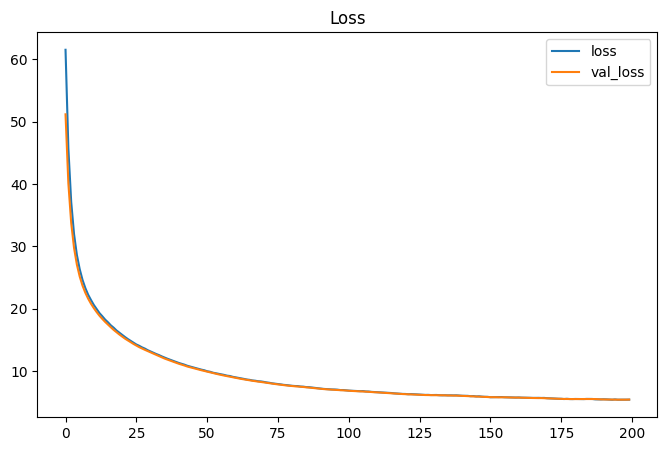

In [624]:
_ = pd.DataFrame(
    {k: v for k, v in history.history.items() if k in ("loss", "val_loss")}
).plot(figsize=(8, 5), title="Loss")

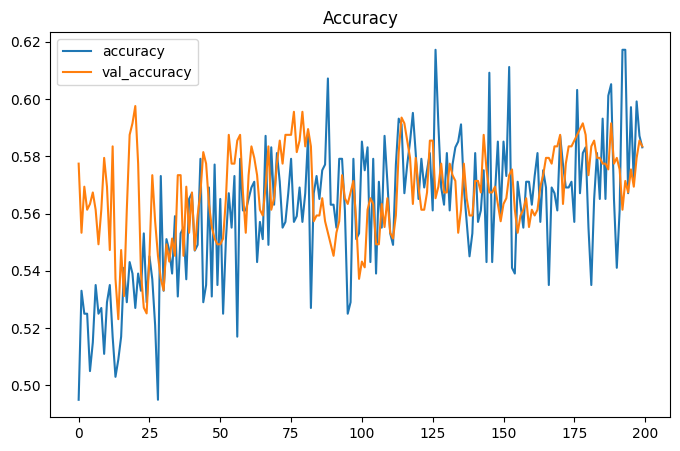

In [625]:
_ = pd.DataFrame(
    {k: v for k, v in history.history.items() if k in ("accuracy", "val_accuracy")}
).plot(figsize=(8, 5), title="Accuracy")

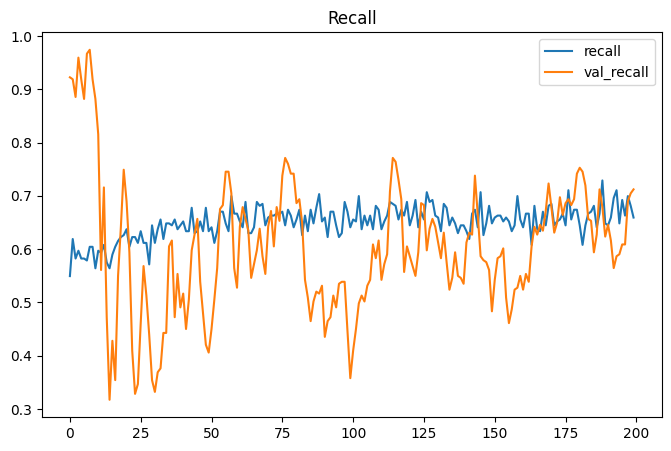

In [626]:
_ = pd.DataFrame(
    {k: v for k, v in history.history.items() if k in ("recall", "val_recall")}
).plot(figsize=(8, 5), title="Recall")

## Model B
Lots of batch normalization